<a href="https://colab.research.google.com/github/BDavidoff/Data620/blob/master/Copy_of_DATA620_Project1_GDavis_BDavidoff_PGatica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA620: Project 1
#### by Glen Davis, Brett Davidoff, and Peter Gatica

In [ ]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import seaborn as sns

## Introduction

We load anonymized node, edge, and feature data for several Facebook users' ego networks from [the SNAP library's collection of large social network datasets](https://snap.stanford.edu/data/ego-Facebook.html). Each node is a user, each edge indicates two users are Facebook friends, and the anonymized features recorded for each user vary, but are based on profile information the users have shared.

In [ ]:
base = "https://raw.githubusercontent.com/geedoubledee/data620_project1/main/data/"
url = base + "file_list.txt"
files = pd.read_csv(url).iloc[:, 0].to_list()
# Create dictionary with node/edge data for every ego network
edges_data = {}
def read_edges(filename):
    return pd.read_csv(filename, sep=' ', header=None, names=['node1', 'node2'])
for file in files:
    if file.endswith('.edges'):
        key = file.split('.edges')[0]
        edges_data[key] = read_edges(base + file)
# Get col names for every ego network's features
def get_col_names(filename):
    df = pd.read_csv(filename + "names", sep = "^[^\s]+", engine="python", names = ["col_id", "col_name"], index_col = 0)
    col_names = df.iloc[:, 0].to_list()
    col_names = [x.strip(' ') for x in col_names]
    return col_names
# Create dictionary with node/feature data for every ego network
feat_data = {}
def read_features(filename):
    cols = get_col_names(filename)
    df = pd.read_csv(filename, sep=' ', header=None, names = cols)
    return df
for file in files:
    if file.endswith('.feat'):
        key = file.split('.feat')[0]
        feat_data[key] = read_features(base + file)

## Analysis

We select the ego network with the smallest number of edges for further analysis since it'll be easier to visualize than the larger ego networks.

In [ ]:
edge_count = {}
for k, v in edges_data.items():
    edge_count[k] = len(v)
sorted_edge_count = sorted(edge_count.items(), key=lambda x: x[1])
print(sorted_edge_count[0])

('3980', 292)


The ego network for Facebook user 3980 has the smallest number of edges at 292. We build and visualize the graph below.

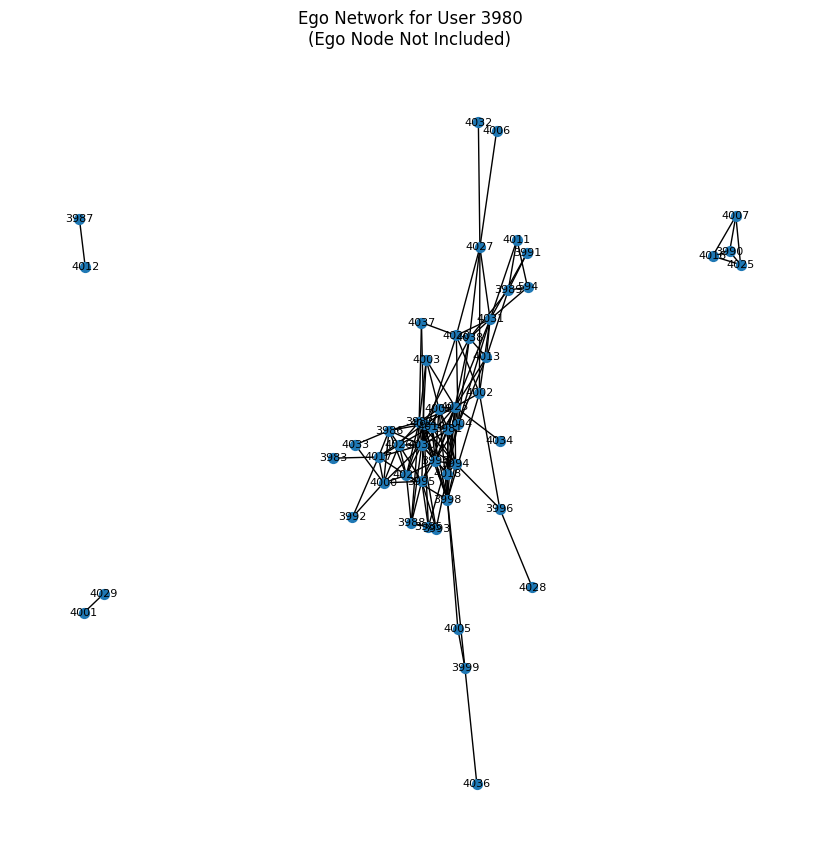

In [ ]:
selection = sorted_edge_count[0][0]
G = nx.Graph()
# Add edges to the graph
for index, row in edges_data[selection].iterrows():
    G.add_edge(row['node1'], row['node2'])
# Draw the network
plt.figure(figsize=(8, 8))
nx.draw(G, with_labels=True, node_size=50, font_size=8)
plt.title(f'Ego Network for User {selection}\n(Ego Node Not Included)')
plt.show()

In [ ]:
G_info = {"nodes": G.number_of_nodes(),
          "edges": G.size(),
          "diameter": "NA; Graph Not Connected"}
print(G_info)

{'nodes': 52, 'edges': 146, 'diameter': 'NA; Graph Not Connected'}


The graph has 52 nodes, 146 edges (half the number of edges used to build the graph since the graph is undirected), and no diameter (since the graph is not connected).

Note that node 3980, the ego itself, was intentionally not included in this representation of the network by the data compilers, but in reality the ego node does share an edge with each node in their network. So we build an alternate version of the graph, in which the ego node and all of its edges are included, and we visualize that below. Since the graph is only connected when the ego node is included, we prefer this representation of the network.

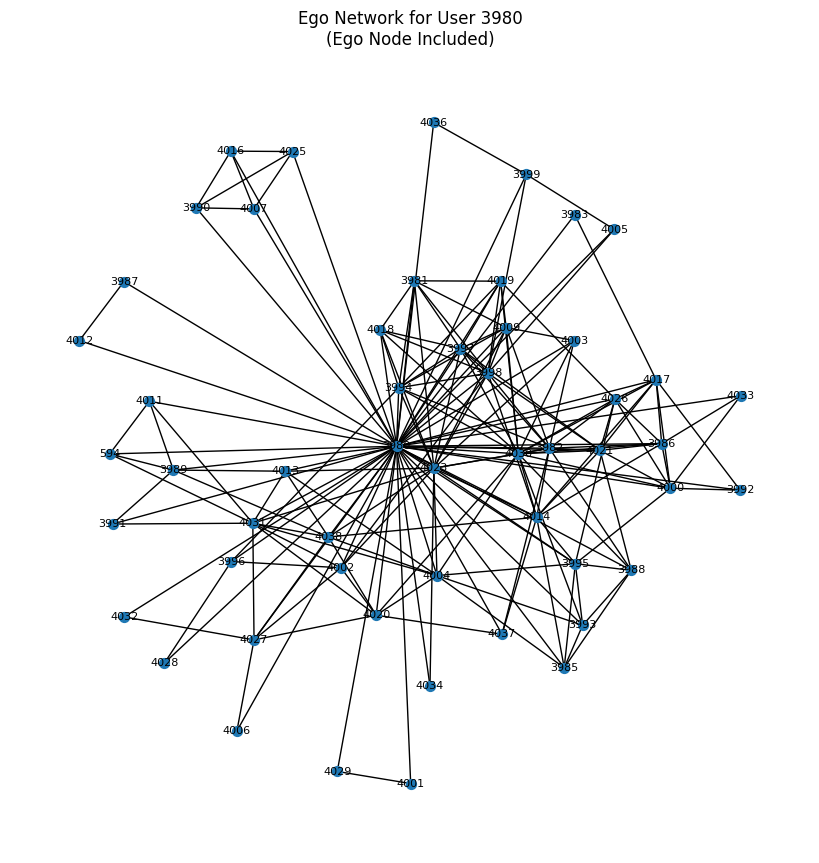

In [ ]:
H = G.copy()
for n in list(H.nodes):
    H.add_edge(int(selection), n)
plt.figure(figsize=(8, 8))
nx.draw(H, with_labels=True, node_size=50, font_size=8)
plt.title(f'Ego Network for User {selection}\n(Ego Node Included)')
plt.show()

In [ ]:
H_info = {"nodes": H.number_of_nodes(),
          "edges": H.size(),
          "diameter": nx.diameter(H)}
print(H_info)

{'nodes': 53, 'edges': 198, 'diameter': 2}


The new graph has 53 nodes, 198 edges, and a diameter of 2 since every user can reach every other user through the ego node. Now we can look at a summary of what we know about these Facebook users.

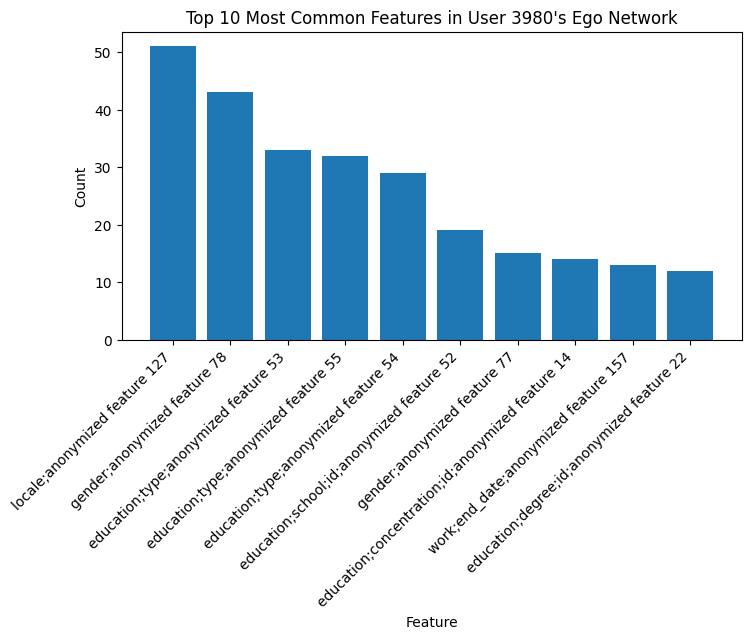

In [ ]:
feature_counts = {}
feat_df = feat_data[selection]
# Add the ego node's features since those were recorded separately
fn = base + "3980.egofeat"
new_row = pd.read_csv(fn, sep=' ', header=None, names = feat_df.columns)
new_row.rename(index = {0: 3980}, inplace = True)
feat_df = pd.concat([feat_df, new_row])
# Sum up the occurrences of each feature
for feature in feat_df.columns:
    feature_counts[feature] = feat_df[feature].sum()
# Convert the feature_counts dictionary to a list of (feature, count) tuples and sort them by count in descending order
sorted_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)
# Select the top N features to visualize
top_n = 10
top_features, top_counts = zip(*sorted_features[:top_n])
# Plotting
plt.figure(figsize=(8, 4))
plt.bar(top_features, top_counts)
plt.xlabel('Feature')
plt.ylabel('Count')
plt.xticks(rotation=45, ha="right")
plt.title(f"Top 10 Most Common Features in User {selection}'s Ego Network")
plt.show()

We see that many users in user 3980's ego network have listed one of two genders (anonymized feature 77 and anonymized feature 78). Since we don't know which gender identities the anonymized features correspond to by design, we rename anonymized feature 77 as Gender A and anonymized feature 78 as Gender B, and we create a third level, Gender U, to indicate a user's gender is unlisted.

In [ ]:
rename = {"gender;anonymized feature 77": "Gender A",
          "gender;anonymized feature 78": "Gender B"}
feat_df.rename(columns = rename, inplace = True)
sub = feat_df.loc[:, ["Gender A", "Gender B"]]
sub["Gender U"] = abs(sub.sum(axis=1) - 1)
sub.reset_index(inplace = True)
sub.rename(columns = {"index": "Node"}, inplace = True)
melt = pd.melt(sub, id_vars = "Node", value_vars = ["Gender A", "Gender B", "Gender U"],
               var_name = "Gender", value_name = "Value")
melt = melt[melt["Value"] == 1]
melt.drop(columns = "Value", inplace = True)
melt["Color"] = "NA"
melt.loc[melt["Gender"] == "Gender A", "Color"] = "#1B9E77"
melt.loc[melt["Gender"] == "Gender B", "Color"] = "#D95F02"
melt.loc[melt["Gender"] == "Gender U", "Color"] = "#7570B3"

We now represent the graph with the gender of the nodes color-coded.

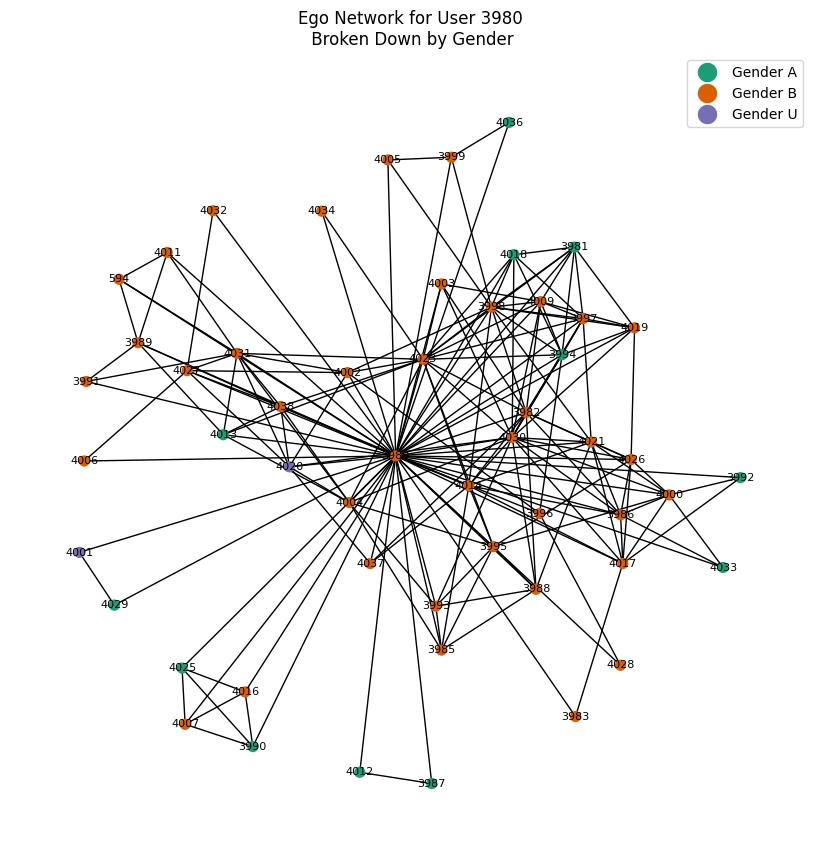

In [ ]:
gender_dict = melt.set_index("Node")["Gender"].to_dict()
color_dict = melt.set_index("Node")["Color"].to_dict()
nx.set_node_attributes(H, gender_dict, name = "Gender")
nx.set_node_attributes(H, color_dict, name = "Color")
plt.figure(figsize=(8, 8))
colors = [n[1]["Color"] for n in H.nodes(data=True)]
nx.draw(H, with_labels=True, node_color = colors, node_size=50, font_size = 8)
legend_elements = [Line2D([0], [0], marker='o', color='w', label="Gender A",
                          markerfacecolor="#1B9E77", markersize=15),
                   Line2D([0], [0], marker='o', color='w', label="Gender B",
                          markerfacecolor="#D95F02", markersize=15),
                   Line2D([0], [0], marker='o', color='w', label="Gender U",
                          markerfacecolor="#7570B3", markersize=15)]
plt.legend(handles=legend_elements, loc='upper right')
plt.title(f'Ego Network for User {selection}\n Broken Down by Gender')
plt.show()